<a href="https://colab.research.google.com/github/harshk2402/Machine-Learning-in-Finance/blob/main/Assigments%2BClasswork/Nixtla_Playground.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
%%capture
!pip install statsforecast

In [ ]:
##########
import os
import pandas as pd
import numpy as np
import plotly.graph_objs as go
from plotly.subplots import make_subplots
from scipy.stats import norm
from statsforecast import StatsForecast
from statsforecast.models import (
    HoltWinters,
    CrostonClassic as Croston,
    HistoricAverage,
    DynamicOptimizedTheta as DOT,
    SeasonalNaive,
    AutoARIMA
)
from utilsforecast.losses import mse
from utilsforecast.evaluation import evaluate

# Set environment variable
os.environ['NIXTLA_ID_AS_COL'] = '1'

##########
# Read the data
Y_df = pd.read_parquet('https://raw.githubusercontent.com/firmai/random-assets-two/master/AirQualityUCI.csv')



In [ ]:
Y_df["unique_id"].value_counts()

,count
unique_id,
H286,1008
H283,1008
H290,1008
H289,1008
H288,1008
...,...
H163,748
H164,748
H165,748


In [ ]:
Y_df.head()

,unique_id,ds,y
0,H1,1,605.0
1,H1,2,586.0
2,H1,3,586.0
3,H1,4,559.0
4,H1,5,511.0


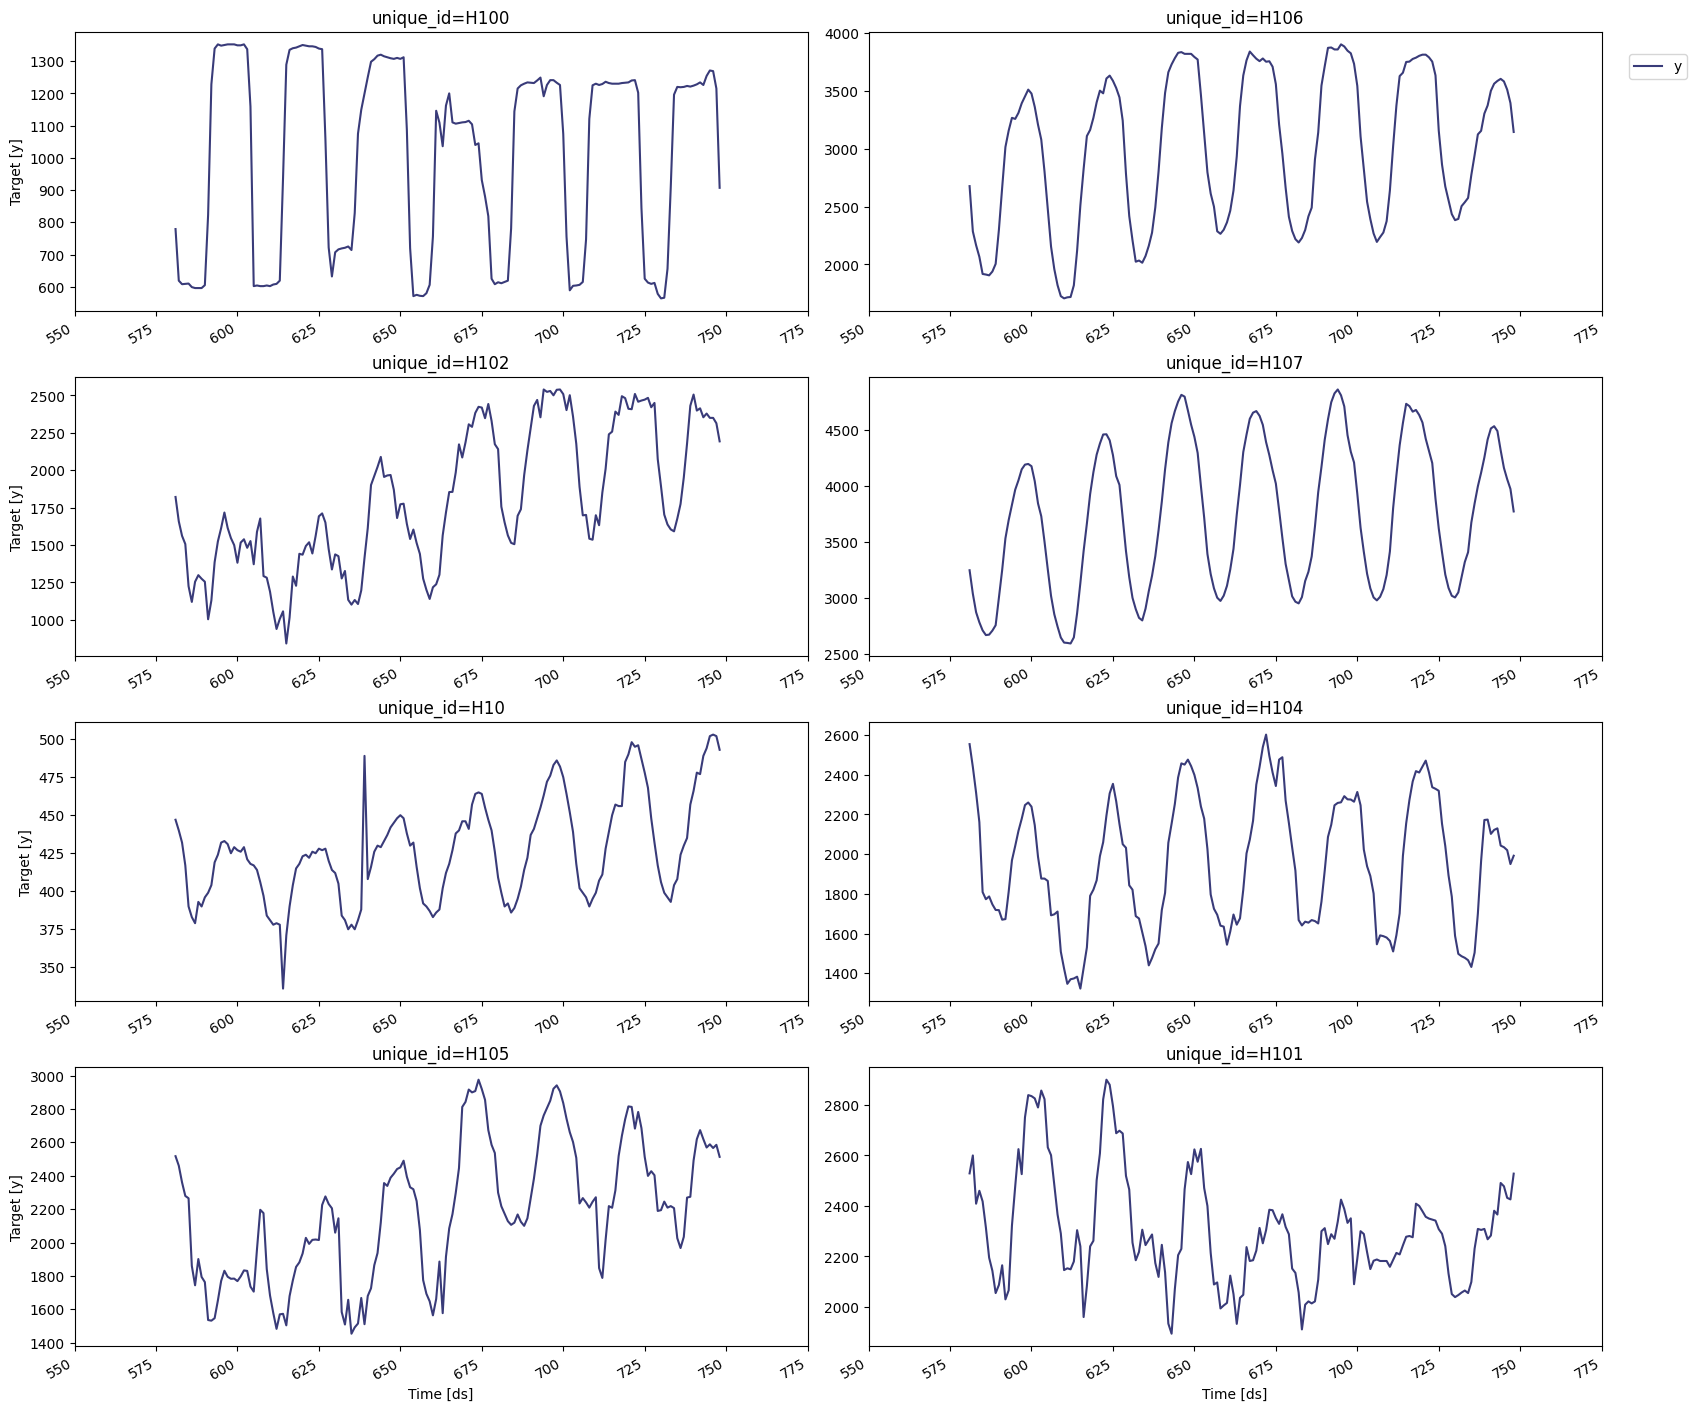

In [ ]:
# Select subset of data
uids = Y_df['unique_id'].unique()[:10]
Y_df = Y_df.query('unique_id in @uids')
Y_df = Y_df.groupby('unique_id').tail(7 * 24)

##########
# Explore data
StatsForecast.plot(Y_df)



1. HoltWinters: Triple exponential smoothing, good for data with both trend and seasonality.
1. Croston: Designed for intermittent demand forecasting.
1. SeasonalNaive(season_length=24): Uses the value from the same time in the previous season. The season_length=24 suggests hourly data with daily seasonality.
1. HistoricAverage: Uses the mean of all historical data points.
1. DOT (Dynamic Optimized Theta): A variant of the Theta method, good for data with seasonality.

In [ ]:
##########
# Define models
models = [
    HoltWinters(),
    Croston(),
    SeasonalNaive(season_length=24),
    HistoricAverage(),
    DOT(season_length=24),
    # AutoARIMA(season_length=24) ## slightly slow ignoring for now
]

#The season_length=24 refers to hourly data with daily seasonality.

# Instantiate StatsForecast
sf = StatsForecast(
    models=models,
    freq=1,
    fallback_model = SeasonalNaive(season_length=7), ## if other models fail
    n_jobs=-1,
)



* df=Y_df: The input data frame.
* h=48: Forecast horizon of 48 time units (likely 48 hours).
* level=[90]: Generates 90% prediction intervals.

In [ ]:
# Generate forecasts
forecasts_df = sf.forecast(df=Y_df, h=48, level=[90])

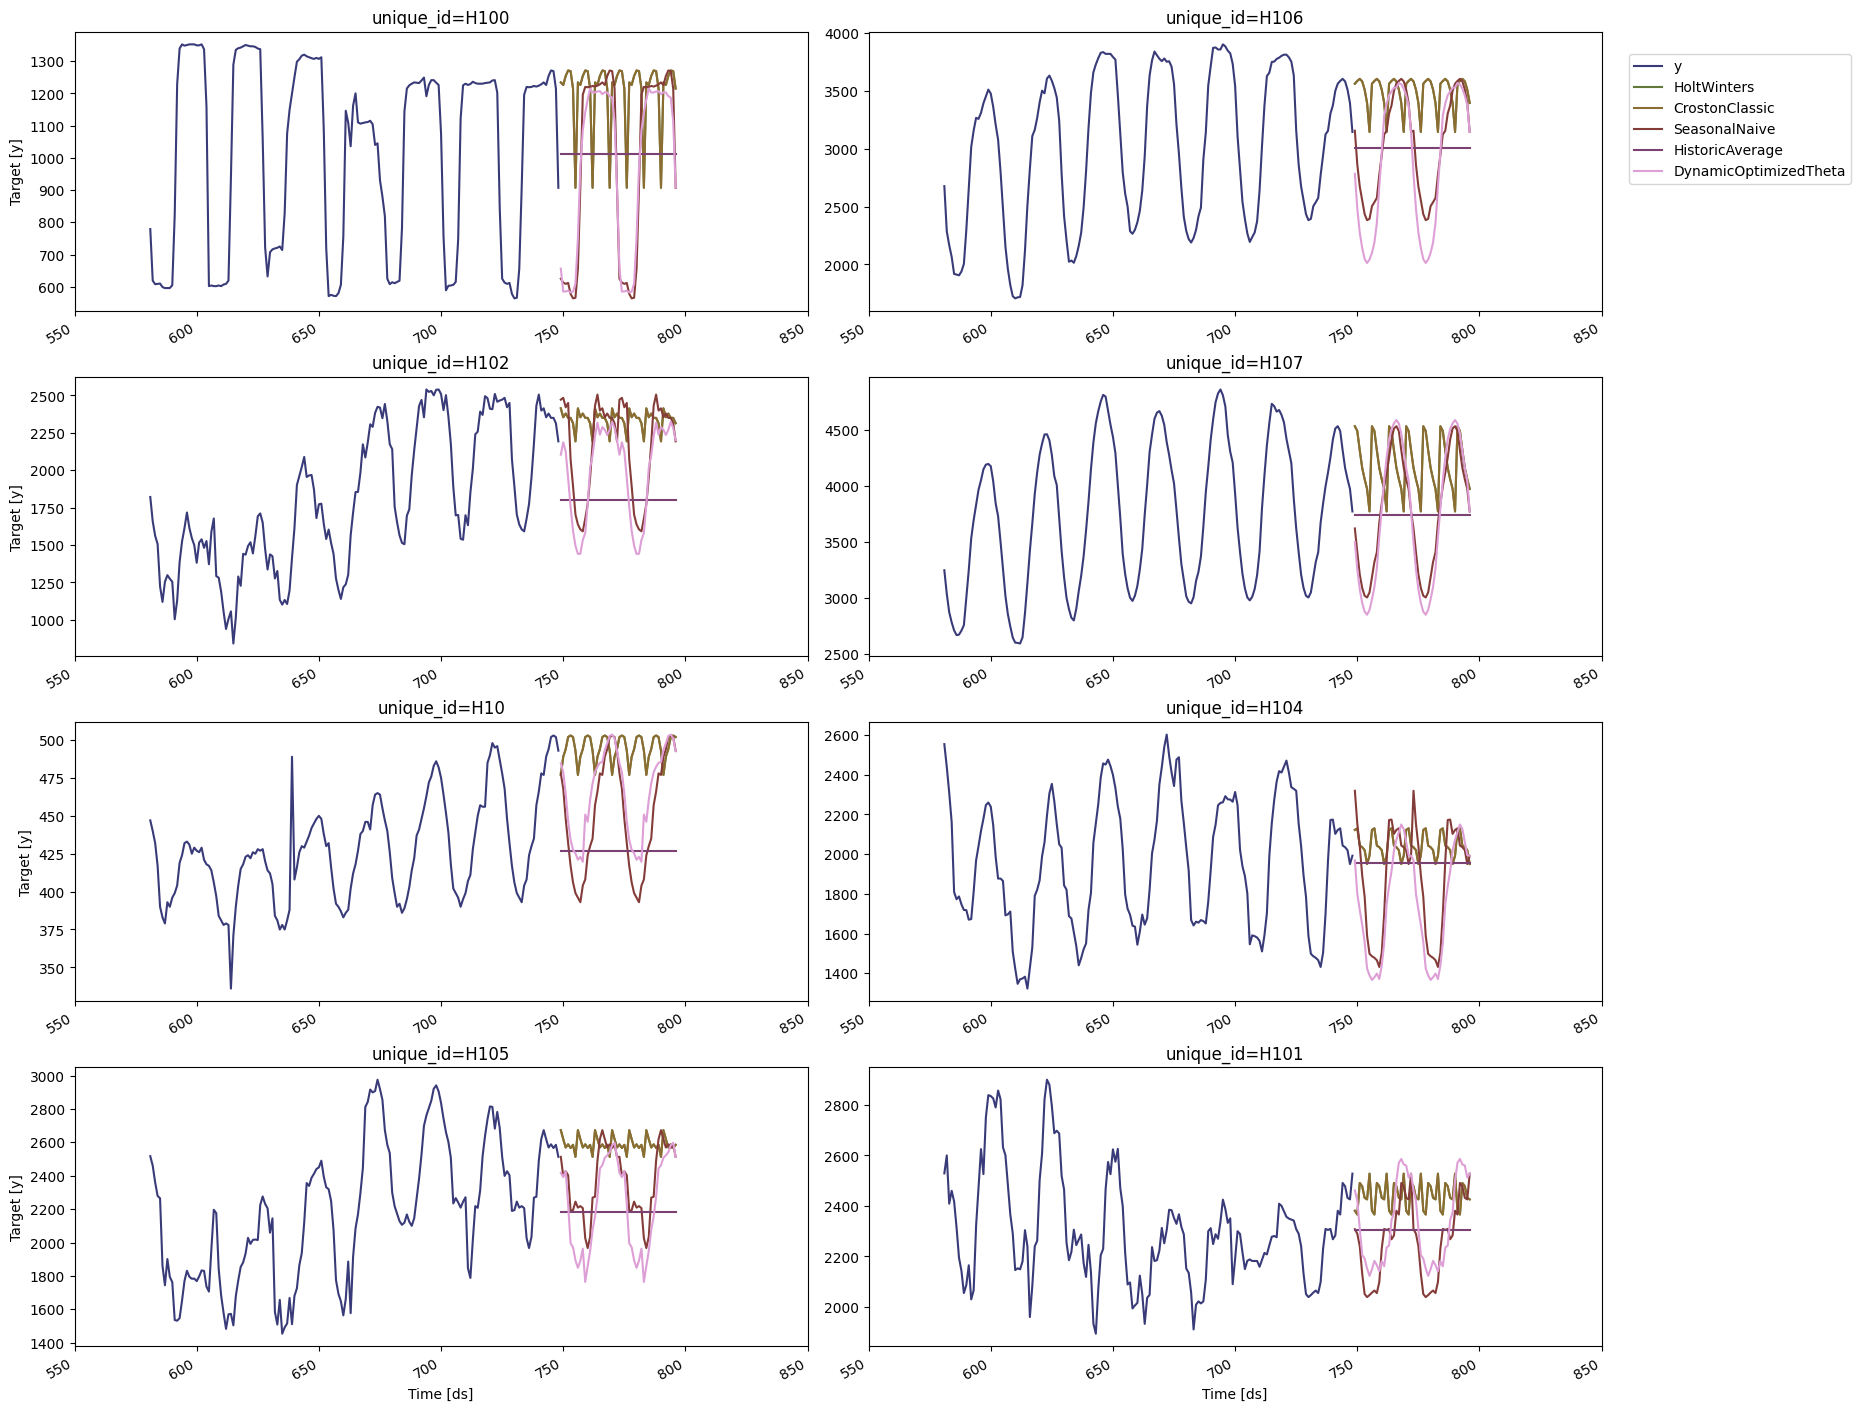

In [ ]:
##########
# Plot forecasts
sf.plot(Y_df, forecasts_df)

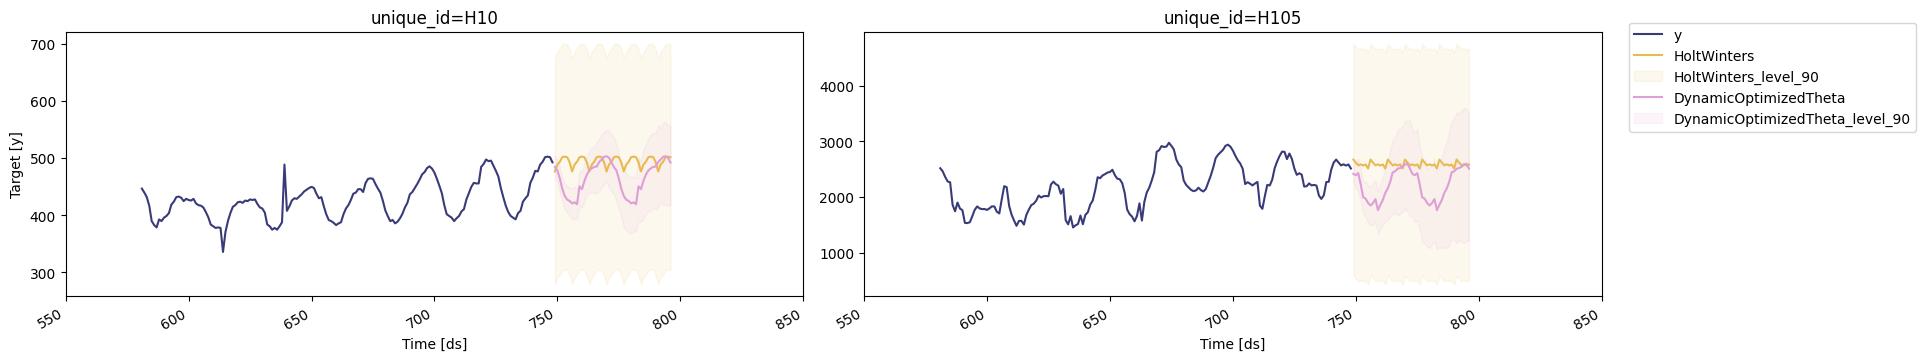

In [ ]:
sf.plot(Y_df, forecasts_df, models=["HoltWinters","DynamicOptimizedTheta"], unique_ids=["H10", "H105"], level=[90])


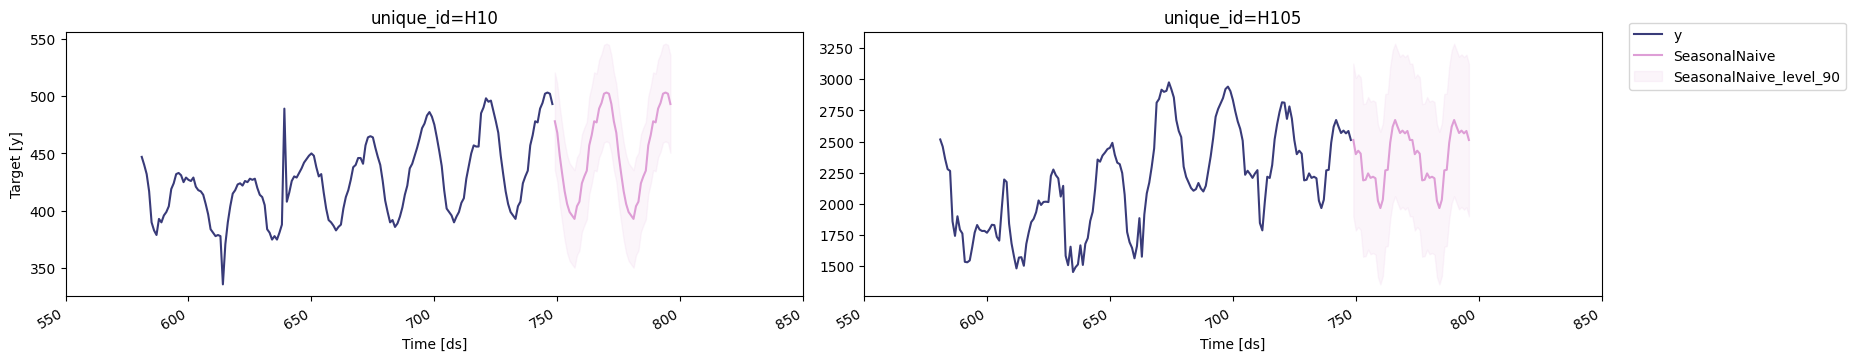

In [ ]:
sf.plot(Y_df, forecasts_df, models=["SeasonalNaive"], unique_ids=["H10", "H105"], level=[90])

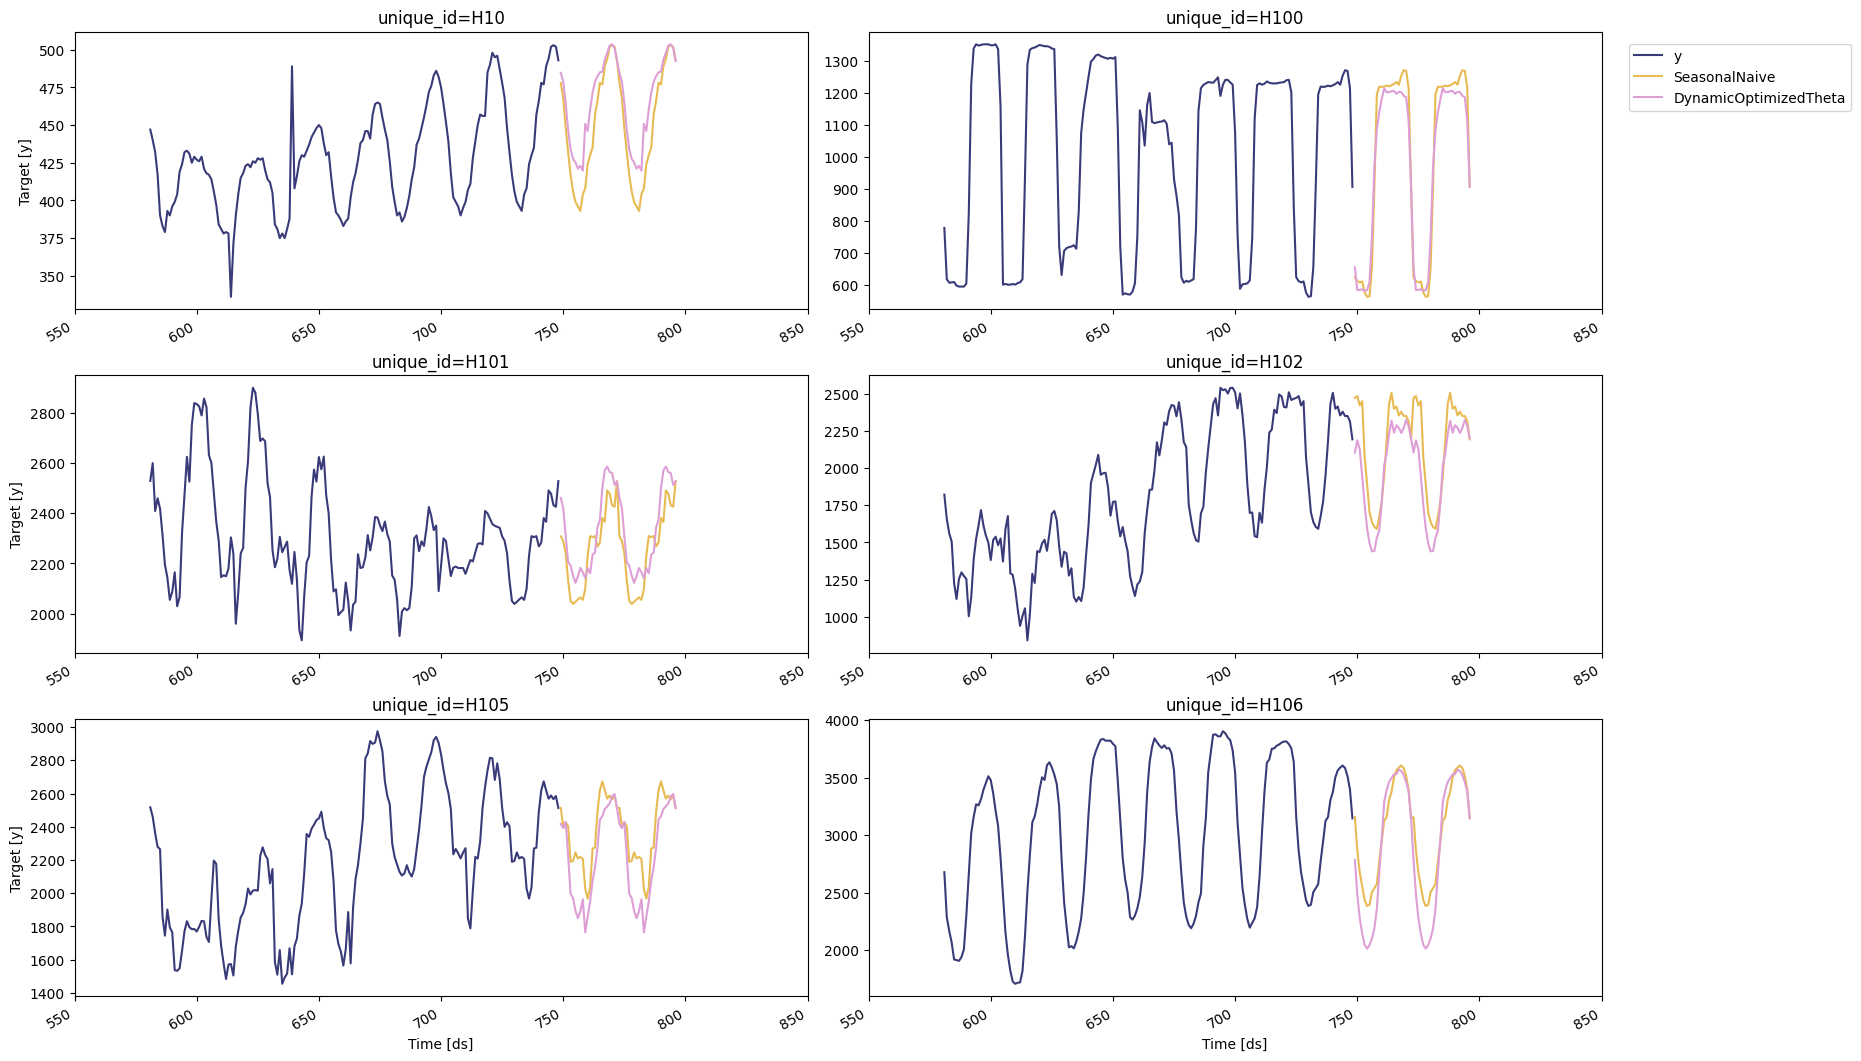

In [ ]:
##########
# Cross-validation
crossvaldation_df = sf.cross_validation(
    df=Y_df,
    h=24,
    step_size=24,
    n_windows=2
)

##########
# Evaluation function
def evaluate_cross_validation(df, metric):
    models = df.drop(columns=['unique_id', 'ds', 'cutoff', 'y']).columns.tolist()
    evals = []
    for cutoff in df['cutoff'].unique():
        eval_ = evaluate(df[df['cutoff'] == cutoff], metrics=[metric], models=models)
        evals.append(eval_)
    evals = pd.concat(evals)
    evals = evals.groupby('unique_id').mean(numeric_only=True)
    evals['best_model'] = evals.idxmin(axis=1)
    return evals

# Evaluate models
evaluation_df = evaluate_cross_validation(crossvaldation_df, mse)

# Create summary
summary_df = evaluation_df.groupby('best_model').size().sort_values().to_frame()
summary_df.reset_index().columns = ["Model", "Nr. of unique_ids"]

# Plot best model for specific IDs
seasonal_ids = evaluation_df.query('best_model == "SeasonalNaive"').index
sf.plot(Y_df, forecasts_df, unique_ids=seasonal_ids, models=["SeasonalNaive","DynamicOptimizedTheta"])

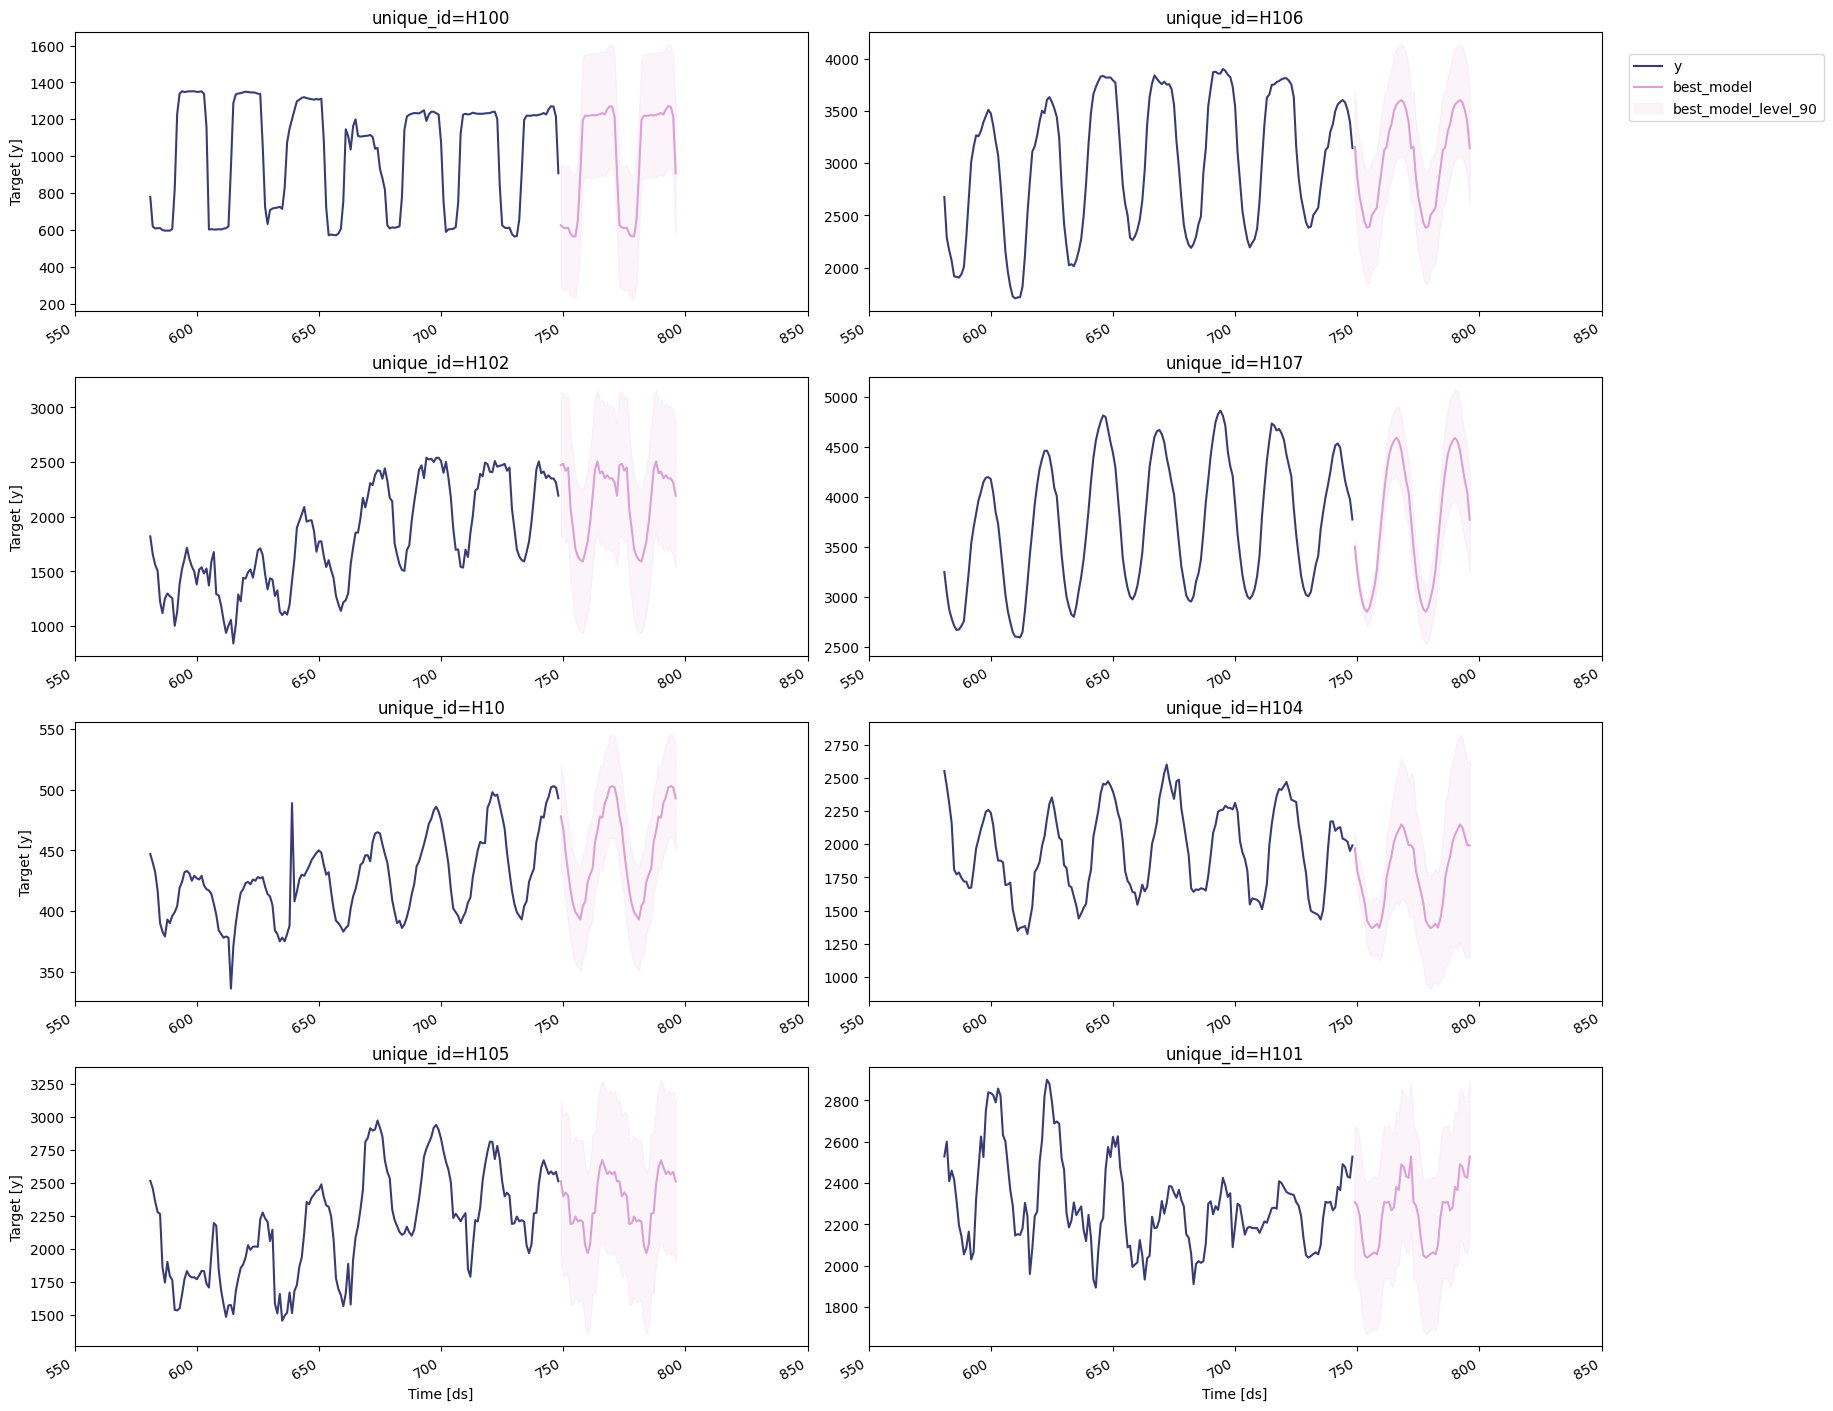

In [ ]:
##########
# Select best model for each series
def get_best_model_forecast(forecasts_df, evaluation_df):
    df = forecasts_df.set_index(['unique_id', 'ds']).stack().to_frame().reset_index(level=2)
    df.columns = ['model', 'best_model_forecast']
    df = df.join(evaluation_df[['best_model']])
    df = df.query('model.str.replace("-lo-90|-hi-90", "", regex=True) == best_model').copy()
    df.loc[:, 'model'] = [model.replace(bm, 'best_model') for model, bm in zip(df['model'], df['best_model'])]
    df = df.drop(columns='best_model').set_index('model', append=True).unstack()
    df.columns = df.columns.droplevel()
    df.columns.name = None
    df = df.reset_index()
    return df

# Get best model forecasts
prod_forecasts_df = get_best_model_forecast(forecasts_df, evaluation_df)

# Plot final results
sf.plot(Y_df, prod_forecasts_df, level=[90])

##########